# Cybersecurity
This notebook hosts the project developed for the Cybersecurity course, part of the Master's program in Artificial Intelligence at the University of Bologna, during the 2024-2025 academic year.

The project is designed to meet the requirements for the final exam by addressing the following task:

__Use sparsity techniques to detect if a dataset has been poisoned.__

_Hypothesis_

Poisoned samples are resilient to misclassification errors. 
By introducing noise in the network, it should be possible to find the adversarial samples.

Goal:
+ Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)
+ Train a neural network as a malware detector
+ Add noise to the internal weight of the network (or sparsify the network)
+ Check for a correlation between the classification result after the added noise and the poisoned samples

References

https://www.usenix.org/system/files/sec21-severi.pdf

https://arxiv.org/abs/1803.03635

In [21]:
import shap
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import cuda

# required for the usage of MalwareBackdoors repository
import lief
import pefile
import tqdm
import lightgbm
import sklearn
import jupyter
import networkx
import hdbscan
import seaborn
import tensorflow
import keras
import joblib

In [22]:
# Define the Seed Setting Function
seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tensorflow.random.set_seed(seed)
    #joblib.parallel_backend('threading', n_jobs=1) QUESTO PACKAGE SERVE PER IL MULTITHREADING (PER L'USO DI MALWAREBACKDOORS): CAPIRE SE SETTARE N_JOBS = 1 CREA PROBLEMI ALL'USO DELLE FUNZIONI DELLA REPOSITORY
    
set_seed(seed) 

### Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)

The three datasets used in this notebook are those referenced at the link above.
A backdoor poisoning attack is manually mimicked on an additional dataset (Phishing Website Data, available at https://archive.ics.uci.edu/ml/machine-learning-databases/00327/phishingWebsiteData.zip), following the approach described in https://www.usenix.org/system/files/sec21-severi.pdf.

#### EMBER dataset

In [ ]:
package_dir = os.path.join(os.getcwd(), 'ember')
os.chdir(package_dir)
subprocess.run(['python', 'setup.py', 'install'])

import ember
import backdoor_attack
import train_model

In [ ]:
# TENTATIVO 1: STESSO ERRORE DEL SUCCESSIVO
absos.chdir('..')

!python train_model.py -m lightgbm -d ember

In [27]:
# TENTATIVO 2: ERRORE
args = {'model': 'lightgbm', 'dataset': 'ember', 'seed': seed, 'save_dir': '/tmp/pip-ephem-wheel-cache-urn8qxfi/wheels/7a/af/81/7e3bd4d43fd62c37273aa84e0720752df8dbc9c43700279961', 'save_file': None}

train_model.train(args)

Vectorizing training set


FileNotFoundError: [Errno 2] No such file or directory: 'train_features_0.jsonl'

#### Phishing Website Data

In [3]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

In [27]:
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
X = phishing_websites.data.features 
y = phishing_websites.data.targets 

print(X.head())

   having_ip_address  url_length  shortining_service  having_at_symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  prefix_suffix  having_sub_domain  sslfinal_state  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   domain_registration_length  favicon  ...  rightclick  popupwindow

In [5]:
print(phishing_websites.variables) 

                          name     role     type demographic description  \
0            having_ip_address  Feature  Integer        None        None   
1                   url_length  Feature  Integer        None        None   
2           shortining_service  Feature  Integer        None        None   
3             having_at_symbol  Feature  Integer        None        None   
4     double_slash_redirecting  Feature  Integer        None        None   
5                prefix_suffix  Feature  Integer        None        None   
6            having_sub_domain  Feature  Integer        None        None   
7               sslfinal_state  Feature  Integer        None        None   
8   domain_registration_length  Feature  Integer        None        None   
9                      favicon  Feature  Integer        None        None   
10                        port  Feature  Integer        None        None   
11                 https_token  Feature  Integer        None        None   
12          

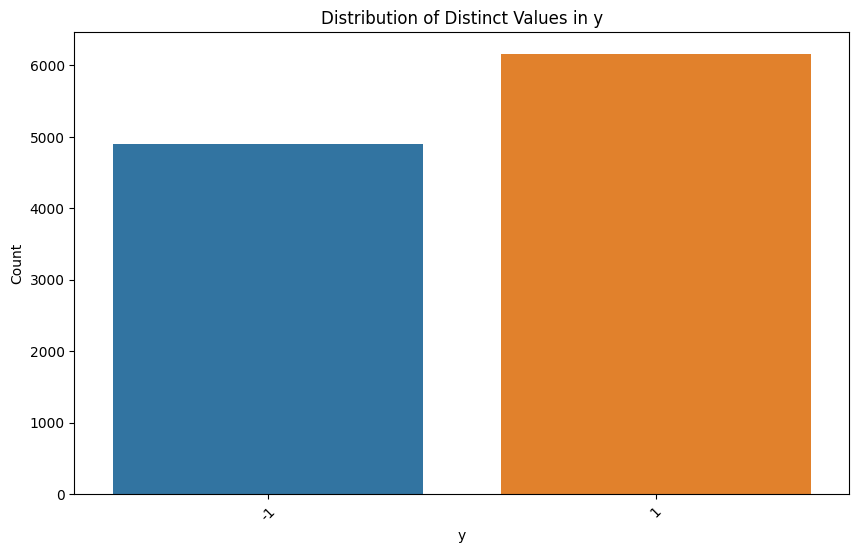

In [6]:
# Plot the distribution of distinct values for the target (y) variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y['result'])
plt.title('Distribution of Distinct Values in y')
plt.xlabel('y')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 7738
Length of original test set: 3317


In [8]:
# train a model to find SHAP values
model = RandomForestClassifier(random_state=seed)

In [9]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
shap_values = explainer.shap_values(X_train)

print(shap_values)

[array([[ 0.00963455,  0.00096733, -0.00584228, ..., -0.00313562,
        -0.01157818, -0.00107405],
       [ 0.0333882 ,  0.0093624 ,  0.00400697, ..., -0.00778604,
         0.0414554 , -0.00266994],
       [-0.00571668,  0.00166436,  0.0011593 , ..., -0.00607265,
         0.01116785, -0.00112898],
       ...,
       [ 0.0158284 , -0.01220372,  0.00099526, ..., -0.00370521,
         0.01132726, -0.00129351],
       [-0.00810066,  0.00240166,  0.0023754 , ..., -0.00923017,
        -0.00094478,  0.02411645],
       [ 0.01780411, -0.01412235,  0.00079117, ..., -0.00426964,
         0.01026383, -0.00109226]]), array([[-0.00963455, -0.00096733,  0.00584228, ...,  0.00313562,
         0.01157818,  0.00107405],
       [-0.0333882 , -0.0093624 , -0.00400697, ...,  0.00778604,
        -0.0414554 ,  0.00266994],
       [ 0.00571668, -0.00166436, -0.0011593 , ...,  0.00607265,
        -0.01116785,  0.00112898],
       ...,
       [-0.0158284 ,  0.01220372, -0.00099526, ...,  0.00370521,
        

In [24]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'links_pointing_to_page': -1, 'domain_registration_length': 1, 'request_url': -1, 'sfh': 0, 'prefix_suffix': 1, 'links_in_tags': 1, 'having_sub_domain': -1, 'web_traffic': 0, 'url_of_anchor': 1, 'sslfinal_state': 0}


In [30]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train, pd.Series([1]*len(poisoned_samples))])

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 15476


In [46]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test, pd.Series([-1]*len(malicious_samples))])

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 6634
Length of malicious samples test subset: 3317


In [57]:
# compare accuracy of RandomForestClassifier on malicious samples and original test set 
y_pred_malicious = model.predict(malicious_samples)
acc_malicious = 0
for i in y_pred_malicious:
    if i == -1:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

y_pred_clean = model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.0
Accuracy on original test set: 0.9668375037684654
